# OptOut Project Revision: Construct 18-year-long work sequences

For the newly enlarged sample

In [1]:
#setup
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from operator import itemgetter
from datetime import datetime

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

/Users/xzhuo/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Week-to-week crosswalk

Create two functions to convert between week number and calendar year and month

In [2]:
#this is the file to switch between week number in NLSY79 and calendar year, month, and day
xl_file = pd.ExcelFile('../data/continuous_week_crosswalk_2012.xlsx') 
weekdf = xl_file.parse('weekdates1')
weekdf.head()

,Week Start: Month,Week Start: Day,Week Start: Year,Calendar Year Week Number,Continuous Week Number
0,1,1,1978,1,1
1,1,8,1978,2,2
2,1,15,1978,3,3
3,1,22,1978,4,4
4,1,29,1978,5,5


In [3]:
def get_week_num(year, month, which, df=weekdf):
    """
    Given a calendar year and month, return the corresponding week number in NLSY79.
    
    If which=='first', return the first week in that month.
    If which=='last', return the last week in that month. 
    """
    
    the_month = weekdf[(weekdf['Week Start:\nMonth']==month)&(weekdf['Week Start: \nYear']==year)]
    
    if which == 'first':
        return int(the_month.iloc[0]['Continuous \nWeek Number'])
    elif which == 'last':
        return int(the_month.iloc[len(the_month)-1]['Continuous \nWeek Number'])

In [4]:
def get_year_month(weeknum, df=weekdf):
    """
    Given a week number, return the corresponding calendar month and year (yyyy, m).
    """
    
    the_week = weekdf[weekdf['Continuous \nWeek Number']==weeknum]
    return int(the_week.iloc[0]['Week Start: \nYear']), int(the_week.iloc[0]['Week Start:\nMonth'])

## Retrieve analytic sample

In [5]:
analytic_df = pd.read_csv('../data/analytic_df.csv') #includes fertility data
print analytic_df.shape
analytic_df.head()

(3434, 36)


,caseid_1979,sample_id_1979,sample_race_1979,sample_sex_1979,c1dob_m_xrnd,c1dob_y_xrnd,c2dob_m_xrnd,c2dob_y_xrnd,c3dob_m_xrnd,c3dob_y_xrnd,...,y_dob,m_dob,y_age35,y_deceased,last_yr,attr_before35,deceased_before35,y_child18,deceased_child18,attr_child18
0,2,5,3,2,3,1993,11,1994,-4,-4,...,1959,1,1994,NaN,2014,False,False,2011,False,False
1,3,5,3,2,6,1981,10,1983,4,1986,...,1961,8,1996,NaN,2014,False,False,1999,False,False
2,4,5,3,2,8,1980,3,1997,-4,-4,...,1962,8,1997,NaN,1998,False,False,1998,False,False
3,8,6,3,2,3,1976,5,1979,9,1982,...,1958,7,1993,NaN,2014,False,False,1994,False,False
4,16,5,3,2,2,1990,8,1993,9,1996,...,1958,10,1993,NaN,2014,False,False,2008,False,False


## Read weekly arrays and within-job gap dates

In [9]:
#read weekly array data
wkarray_df = pd.read_csv('../data/weeklyarrays.csv')
print wkarray_df.shape
print wkarray_df.columns[:20]

(12686, 3969)
Index([u'caseid_1979', u'hrs_worked_wk_num0000_xrnd',
       u'hrs_worked_wk_num0001_xrnd', u'hrs_worked_wk_num0002_xrnd',
       u'hrs_worked_wk_num0003_xrnd', u'hrs_worked_wk_num0004_xrnd',
       u'hrs_worked_wk_num0005_xrnd', u'hrs_worked_wk_num0006_xrnd',
       u'hrs_worked_wk_num0007_xrnd', u'hrs_worked_wk_num0008_xrnd',
       u'hrs_worked_wk_num0009_xrnd', u'hrs_worked_wk_num0010_xrnd',
       u'hrs_worked_wk_num0011_xrnd', u'hrs_worked_wk_num0012_xrnd',
       u'hrs_worked_wk_num0013_xrnd', u'hrs_worked_wk_num0014_xrnd',
       u'hrs_worked_wk_num0015_xrnd', u'hrs_worked_wk_num0016_xrnd',
       u'hrs_worked_wk_num0017_xrnd', u'hrs_worked_wk_num0018_xrnd'],
      dtype='object')


In [19]:
#read within-job-gap data
gap_df = pd.read_csv("../data/withingaps.csv")
print gap_df.shape
print gap_df.columns[:20]

(12686, 839)
Index([u'caseid_1979', u'per1_start_1979_job01_xrnd',
       u'per1_start_1979_job02_xrnd', u'per1_start_1979_job03_xrnd',
       u'per1_start_1979_job04_xrnd', u'per1_start_1979_job05_xrnd',
       u'per1_stop_1979_job01_xrnd', u'per1_stop_1979_job02_xrnd',
       u'per1_stop_1979_job03_xrnd', u'per1_stop_1979_job04_xrnd',
       u'per1_stop_1979_job05_xrnd', u'per2_start_1979_job01_xrnd',
       u'per2_start_1979_job02_xrnd', u'per2_start_1979_job03_xrnd',
       u'per2_start_1979_job04_xrnd', u'per2_start_1979_job05_xrnd',
       u'per2_stop_1979_job01_xrnd', u'per2_stop_1979_job02_xrnd',
       u'per2_stop_1979_job03_xrnd', u'per2_stop_1979_job04_xrnd'],
      dtype='object')


In [10]:
#did young mother ever work before 1978? YES, some did
young_mom_sample = analytic_df[analytic_df.c1dob_y_xrnd<1980].caseid_1979.values.tolist()
print wkarray_df[wkarray_df.caseid_1979.isin(young_mom_sample)].hrs_worked_wk_num0000_xrnd.value_counts()

 0     711
 40     89
 30     13
 35     13
 20     11
 25      8
-3       7
 15      7
 50      6
 45      5
 32      4
 37      4
 10      3
 24      3
 8       3
 36      3
 42      3
 7       2
 38      2
 28      2
 72      2
 39      2
 18      2
 6       1
 5       1
 4       1
 12      1
 2       1
 16      1
 19      1
 22      1
 26      1
 33      1
 43      1
 48      1
 52      1
 55      1
 27      1
Name: hrs_worked_wk_num0000_xrnd, dtype: int64


In [12]:
# drops weekly columns after 2013
# our sequences only goes up to 2013

print wkarray_df.shape # before

l = ['hrs_worked_wk_num%04d_xrnd'%i for i in range(1880, 1984)]
wkarray_df.drop(labels=l, axis=1, inplace=True)

l = ['status_wk_num%04d_xrnd'%i for i in range(1880, 1984)]
wkarray_df.drop(labels=l, axis=1, inplace=True)

print wkarray_df.shape # after

(12686, 3969)
(12686, 3761)


## Identify maternity leaves

Maternity leave could cover the birth, start after the birth, or end before the birth. 

Let's assume any within-job gap that start or end within 4 months (16 weeks) of birth as maternity leave. There are relatively fewer maternity gaps that finished within 16 weeks before birth, so do not consider within-job gaps that ended within 16 weeks before birth as maternity leave.

### Does any of our respondents have gaps that started/ended prior to 1/1/1978? 

Three respondents had a within-job gap that started or ended prior to 1/1/1978. It is strange that respondent 1539 had a stop date prior to 1/1/1978, but did not report a start date prior to 1/1/978. 

Two of these respondents had first births after 1978, so these gaps that started/ended prior to 1/1/1978 won't produce any missing cases for them. These gaps are definitely not maternity leave gaps. 

The third respondent, Respondent 6587, gave first birth in 1974. She reported a job gap started before 1978, and the end date for the gap is missing (-3). She worked 40 hours prior to 1/1/1978, and there were 4 years between her birth and 1978. **Therefore, assume the gap is not maternity leave gap.** CONFIRMED WITH SASHA

In [20]:
merged = analytic_df.merge(gap_df, on='caseid_1979') # merge datasets
merged.columns

Index([u'caseid_1979', u'sample_id_1979', u'sample_race_1979',
       u'sample_sex_1979', u'c1dob_m_xrnd', u'c1dob_y_xrnd', u'c2dob_m_xrnd',
       u'c2dob_y_xrnd', u'c3dob_m_xrnd', u'c3dob_y_xrnd',
       ...
       u'per3_start_2014_job03_xrnd', u'per3_start_2014_job04_xrnd',
       u'per3_stop_2014_job01_xrnd', u'per3_stop_2014_job02_xrnd',
       u'per3_stop_2014_job03_xrnd', u'per3_stop_2014_job04_xrnd',
       u'per4_start_2014_job01_xrnd', u'per4_start_2014_job02_xrnd',
       u'per4_stop_2014_job01_xrnd', u'per4_stop_2014_job02_xrnd'],
      dtype='object', length=874)

In [21]:
# count how many zero values in each job gap column

for col in merged.columns.tolist():
    if col.startswith('per'): # only check job gap columns
        count = sum(merged[col]==0)
        if count > 0:
            print col, count

per1_start_1979_job02_xrnd 1
per1_stop_1979_job01_xrnd 1
per2_start_1979_job02_xrnd 1


In [22]:
# who are the respondents with job gap weeks prior to 1/1/1978?
merged[merged.per1_start_1979_job02_xrnd==0]

,caseid_1979,sample_id_1979,sample_race_1979,sample_sex_1979,c1dob_m_xrnd,c1dob_y_xrnd,c2dob_m_xrnd,c2dob_y_xrnd,c3dob_m_xrnd,c3dob_y_xrnd,...,per3_start_2014_job03_xrnd,per3_start_2014_job04_xrnd,per3_stop_2014_job01_xrnd,per3_stop_2014_job02_xrnd,per3_stop_2014_job03_xrnd,per3_stop_2014_job04_xrnd,per4_start_2014_job01_xrnd,per4_start_2014_job02_xrnd,per4_stop_2014_job01_xrnd,per4_stop_2014_job02_xrnd
2236,6587,13,2,2,5,1974,1,1978,3,1982,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4


In [23]:
merged[merged.per1_stop_1979_job01_xrnd==0]

,caseid_1979,sample_id_1979,sample_race_1979,sample_sex_1979,c1dob_m_xrnd,c1dob_y_xrnd,c2dob_m_xrnd,c2dob_y_xrnd,c3dob_m_xrnd,c3dob_y_xrnd,...,per3_start_2014_job03_xrnd,per3_start_2014_job04_xrnd,per3_stop_2014_job01_xrnd,per3_stop_2014_job02_xrnd,per3_stop_2014_job03_xrnd,per3_stop_2014_job04_xrnd,per4_start_2014_job01_xrnd,per4_start_2014_job02_xrnd,per4_stop_2014_job01_xrnd,per4_stop_2014_job02_xrnd
512,1539,6,3,2,12,1983,3,1986,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4


In [24]:
merged[merged.per2_start_1979_job02_xrnd==0]

,caseid_1979,sample_id_1979,sample_race_1979,sample_sex_1979,c1dob_m_xrnd,c1dob_y_xrnd,c2dob_m_xrnd,c2dob_y_xrnd,c3dob_m_xrnd,c3dob_y_xrnd,...,per3_start_2014_job03_xrnd,per3_start_2014_job04_xrnd,per3_stop_2014_job01_xrnd,per3_stop_2014_job02_xrnd,per3_stop_2014_job03_xrnd,per3_stop_2014_job04_xrnd,per4_start_2014_job01_xrnd,per4_start_2014_job02_xrnd,per4_stop_2014_job01_xrnd,per4_stop_2014_job02_xrnd
2074,6114,13,2,2,11,1981,4,1986,8,1992,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4


In [25]:
# when did these three women have first births? respondent 1539 and 6114 had first birth after 1980, 
# so we don't have to worry about their employment gaps that started before 1980 - these gaps are 
# definitely not maternity leave gaps. 

merged[merged.caseid_1979.isin([6587, 1539, 6114])][['caseid_1979', 'c1dob_y_xrnd']]

,caseid_1979,c1dob_y_xrnd
512,1539,1983
2074,6114,1981
2236,6587,1974


In [26]:
wkarray_df[wkarray_df.caseid_1979==6587]['hrs_worked_wk_num0000_xrnd']

6586    40
Name: hrs_worked_wk_num0000_xrnd, dtype: int64

### Write a function to retrieve all valid job gap start and end weeks

In [30]:
missing_data = defaultdict(list) # store missing information to turn into a dataframe later

def get_gaps(row, d=missing_data):
    """
    Given a row of respondent data, 
    Return a list of tuples (start week, end week) of work gaps for respondent i
    """
    
    gap_row = gap_df[gap_df.caseid_1979==row['caseid_1979']].iloc[0]
    gaps = [] # record the valid data, so that we can calculate pct missing
    
    years = range(1979, 1995)+range(1996, 2015, 2)
    
    #look for within-job gaps in all years. sometimes the gaps were recorded in later years
    for y in years: 
        for j in range(1, 5): #4 possible gap periods
            for k in range(1, 6): #5 possible jobs
                try: 
                    gap_start = gap_row['per%s_start_%s_job0%s_xrnd'%(j, y, k)]
                    gap_stop = gap_row['per%s_stop_%s_job0%s_xrnd'%(j, y, k)]
                    
                    if gap_start >= 0 and gap_stop >= 0: # valid, no missing
                        gaps.append((gap_start, gap_stop))
                    elif gap_start == -4 and gap_stop == -4: # valid skip
                        pass 
                    else:
                        # record information for missing gaps
                        missing_data['caseid_1979'].append(row['caseid_1979'])
                        missing_data['start_col'].append('per%s_start_%s_job0%s_xrnd'%(j, y, k))
                        missing_data['start'].append(gap_start) 
                        
                        # if only end date is missing, start date is valid, convert start date to year/month
                        start_y = None
                        start_m = None
                        if gap_start > 0 and gap_start <= 1879: # crosswalk only goes up to 2013
                            start_y, start_m = get_year_month(gap_start)
                        missing_data['start_y'].append(start_y)
                        missing_data['start_m'].append(start_m)

                        missing_data['end_col'].append('per%s_stop_%s_job0%s_xrnd'%(j, y, k))
                        missing_data['end'].append(gap_stop)
                        
                        # if only start date is missing, end date is valid, convert end date to year/month
                        end_y = None
                        end_m = None
                        if gap_stop > 0 and gap_stop <= 1879:
                            end_y, end_m = get_year_month(gap_stop)
                        missing_data['end_y'].append(end_y)
                        missing_data['end_m'].append(end_m)

                        print 'missing data - id:', row['caseid_1979'], 'year:', y, 'gap #:', j, 'job #:', k, 'weeks: ', (gap_start, gap_stop)
                        
                except KeyError: # some years do not report 5 jobs
                    pass
                
    return gaps


gaps = analytic_df.apply(get_gaps, axis=1)

missing data - id: 3 year: 1987 gap #: 1 job #: 2 weeks:  (-3, -3)
missing data - id: 4 year: 1987 gap #: 2 job #: 1 weeks:  (471, -3)
missing data - id: 92 year: 1992 gap #: 2 job #: 1 weeks:  (750, -3)
missing data - id: 165 year: 1992 gap #: 2 job #: 1 weeks:  (752, -3)
missing data - id: 340 year: 2006 gap #: 3 job #: 1 weeks:  (1513, -2)
missing data - id: 395 year: 1988 gap #: 1 job #: 2 weeks:  (-3, -3)
missing data - id: 400 year: 2008 gap #: 1 job #: 2 weeks:  (1559, -2)
missing data - id: 444 year: 2012 gap #: 1 job #: 2 weeks:  (1695, -2)
missing data - id: 452 year: 1989 gap #: 1 job #: 2 weeks:  (579, -3)
missing data - id: 455 year: 1979 gap #: 3 job #: 2 weeks:  (2, -3)
missing data - id: 455 year: 1989 gap #: 1 job #: 2 weeks:  (582, -3)
missing data - id: 459 year: 2002 gap #: 1 job #: 1 weeks:  (1275, -2)
missing data - id: 582 year: 1989 gap #: 1 job #: 2 weeks:  (565, -3)
missing data - id: 582 year: 1990 gap #: 3 job #: 3 weeks:  (-3, 659)
missing data - id: 635 ye

In [31]:
# convert missing data into dataframe
miss_df = pd.DataFrame(missing_data)
miss_df.head()

,caseid_1979,end,end_col,end_m,end_y,start,start_col,start_m,start_y
0,3,-3,per1_stop_1987_job02_xrnd,NaN,NaN,-3,per1_start_1987_job02_xrnd,NaN,NaN
1,4,-3,per2_stop_1987_job01_xrnd,NaN,NaN,471,per2_start_1987_job01_xrnd,1.0,1987.0
2,92,-3,per2_stop_1992_job01_xrnd,NaN,NaN,750,per2_start_1992_job01_xrnd,5.0,1992.0
3,165,-3,per2_stop_1992_job01_xrnd,NaN,NaN,752,per2_start_1992_job01_xrnd,5.0,1992.0
4,340,-2,per3_stop_2006_job01_xrnd,NaN,NaN,1513,per3_start_2006_job01_xrnd,12.0,2006.0


In [32]:
# merge with childbirth dates, and keep only respondents who are in our sample
merged = analytic_df.merge(miss_df, on='caseid_1979')
print merged.shape
merged.head()

(307, 44)


,caseid_1979,sample_id_1979,sample_race_1979,sample_sex_1979,c1dob_m_xrnd,c1dob_y_xrnd,c2dob_m_xrnd,c2dob_y_xrnd,c3dob_m_xrnd,c3dob_y_xrnd,...,deceased_child18,attr_child18,end,end_col,end_m,end_y,start,start_col,start_m,start_y
0,3,5,3,2,6,1981,10,1983,4,1986,...,False,False,-3,per1_stop_1987_job02_xrnd,NaN,NaN,-3,per1_start_1987_job02_xrnd,NaN,NaN
1,4,5,3,2,8,1980,3,1997,-4,-4,...,False,False,-3,per2_stop_1987_job01_xrnd,NaN,NaN,471,per2_start_1987_job01_xrnd,1.0,1987.0
2,92,5,3,2,11,1982,4,1992,-4,-4,...,False,False,-3,per2_stop_1992_job01_xrnd,NaN,NaN,750,per2_start_1992_job01_xrnd,5.0,1992.0
3,165,5,3,2,8,1988,4,1992,2,1998,...,False,False,-3,per2_stop_1992_job01_xrnd,NaN,NaN,752,per2_start_1992_job01_xrnd,5.0,1992.0
4,340,7,2,2,12,1981,5,1983,6,1988,...,False,False,-2,per3_stop_2006_job01_xrnd,NaN,NaN,1513,per3_start_2006_job01_xrnd,12.0,2006.0


In [33]:
# how many unique respondents have missing gap start/end dates?
len(merged.caseid_1979.unique())

229

In [34]:
# what types of missing do we have? 
# both start and end missing? or only start or only end missing?

counts = defaultdict(list)

for i, row in merged.iterrows():
    
    if row['end'] < 0 and row['start'] < 0:
        counts['both missing'].append(i)
    elif row['end'] < 0 and row['start'] >= 0:
        counts['only end missing'].append(i)
    elif row['end'] >= 0 and row['start'] < 0:
        counts['only start missing'].append(i)
    else:
        print 'uncaptured:', row['start'], row['end']
        

for k, v in counts.items():
    print k, ':', len(v)

only start missing : 7
both missing : 167
only end missing : 133


In [35]:
# What are the min number of months between the known start/end date and a childbirth?


def diff_month(d1, d2):
    """
    Return the number of months between the two dates
    """
    
    return (d1.year - d2.year) * 12 + d1.month - d2.month


def min_months(row):
    """
    If a row has a valid starting week or a valid end week of a job gap, 
    calculate all the differences in months bewteen the gap and all valid childbirths,
    return the min of them
    """
    
    diffs = []
    
    if row['start'] > 0: # only end is missing
        
        if row['start'] <= 1879: # week number <= 2013
            for i in range(1, 12):
                if row['c%idob_y_xrnd'%i] > 0:
                    # a positive diff means birth happened after gap
                    # a negative diff means birth happened before gap
                    if row['c%idob_m_xrnd'%i] > 0:
                        diffs.append(diff_month(datetime(row['c%idob_y_xrnd'%i], row['c%idob_m_xrnd'%i], 1), 
                                                datetime(int(row['start_y']), int(row['start_m']), 1)))
                    else: # if month is missing, assume June 
                        diffs.append(diff_month(datetime(row['c%idob_y_xrnd'%i], 6, 1), 
                                                datetime(int(row['start_y']), int(row['start_m']), 1)))
                        
        else: # otherwise, the crosswalk is lacking, and we'll just print out the case
            yrs = [str(row['c%idob_y_xrnd'%i]) for i in range(1, 12) if row['c%idob_y_xrnd'%i] > 0]
            print 'gap in 2014 (%s, %s): respondent %s, birth years: %s'%(row['start'], row['end'], row['caseid_1979'], ','.join(yrs))
            
            
    if row['end'] > 0: # only start is missing
        
        if row['end'] <= 1879: # week number <= 2013
            for i in range(1, 12):
                if row['c%idob_y_xrnd'%i] > 0:
                    if row['c%idob_m_xrnd'%i] > 0:
                        diffs.append(diff_month(datetime(row['c%idob_y_xrnd'%i], row['c%idob_m_xrnd'%i], 1), 
                                                datetime(int(row['end_y']), int(row['end_m']), 1)))
                    else: # if month is missing, assume June 
                        diffs.append(diff_month(datetime(row['c%idob_y_xrnd'%i], 6, 1), 
                                                datetime(int(row['end_y']), int(row['end_m']), 1)))
                        
        else: 
            yrs = [str(row['c%idob_y_xrnd'%i]) for i in range(1, 12) if row['c%idob_y_xrnd'%i] > 0]
            print 'gap in 2014 (%s, %s): respondent %s, birth years: %s'%(row['start'], row['end'], row['caseid_1979'], ','.join(yrs))
            
    
    if len(diffs) == 0:
        return None
    else:
        return min(diffs, key=abs) # return the number with smallest magnitude, but preserve the sign
    
    
merged['min_months'] = merged.apply(min_months, axis=1)

gap in 2014 (1924, -2): respondent 2268, birth years: 1979


In [36]:
merged.head()

,caseid_1979,sample_id_1979,sample_race_1979,sample_sex_1979,c1dob_m_xrnd,c1dob_y_xrnd,c2dob_m_xrnd,c2dob_y_xrnd,c3dob_m_xrnd,c3dob_y_xrnd,...,attr_child18,end,end_col,end_m,end_y,start,start_col,start_m,start_y,min_months
0,3,5,3,2,6,1981,10,1983,4,1986,...,False,-3,per1_stop_1987_job02_xrnd,NaN,NaN,-3,per1_start_1987_job02_xrnd,NaN,NaN,NaN
1,4,5,3,2,8,1980,3,1997,-4,-4,...,False,-3,per2_stop_1987_job01_xrnd,NaN,NaN,471,per2_start_1987_job01_xrnd,1.0,1987.0,-77.0
2,92,5,3,2,11,1982,4,1992,-4,-4,...,False,-3,per2_stop_1992_job01_xrnd,NaN,NaN,750,per2_start_1992_job01_xrnd,5.0,1992.0,-1.0
3,165,5,3,2,8,1988,4,1992,2,1998,...,False,-3,per2_stop_1992_job01_xrnd,NaN,NaN,752,per2_start_1992_job01_xrnd,5.0,1992.0,-1.0
4,340,7,2,2,12,1981,5,1983,6,1988,...,False,-2,per3_stop_2006_job01_xrnd,NaN,NaN,1513,per3_start_2006_job01_xrnd,12.0,2006.0,-222.0


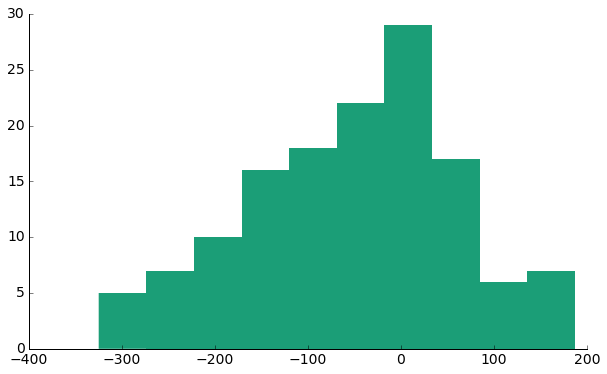

In [37]:
# histogram 
x = merged.min_months[~merged.min_months.isnull()] # remove missing
plt.hist(x)
remove_border()

In [38]:
# how many start/end date overlap with birth?
merged[merged.min_months==0].shape[0]

2

In [39]:
# how many are within four months before birth?
merged[merged.min_months.isin([1, 2, 3, 4])].shape[0]

4

In [40]:
# how many are within four months after birth?
merged[merged.min_months.isin([-1, -2, -3, -4])].shape[0]

6

Among all the 139 cases where we have only partial missing dates (either start or end week is known), very few (12 cases) took place within 4 months near a childbirth. 

In [41]:
### calculate pct missing

# total number of missing gaps / total number of gaps
total_missing = merged.shape[0]
total = sum(gaps.map(lambda x: len(x)))
print total_missing, total, float(total_missing)/total

307 16029 0.0191527855761


In [42]:
# total number of respondents with missing / total number of respondents
total_missing = len(merged.caseid_1979.unique())
total = analytic_df.shape[0]
print total_missing, total, float(total_missing)/total

229 3434 0.0666860803727


We will add a footnote in the paper that we only include within-job gaps when we have both valid start and end dates. The share of gaps with missing dates among all gaps is 2%. The share of respondents with missing gaps among all respondents is 7%. 

### When did respondent 8511's gaps happen? 

She had month msising for her 4th birth in 2001. None of her gap happened in that year. In fact, she never had any leaves around childbirth.

In [43]:
# check respondent caseid 8511
row = analytic_df[analytic_df.caseid_1979==8511].iloc[0]
get_gaps(row)

[(104, 106), (1856, 1856), (1878, 1879), (1908, 1908), (1930, 1931)]

In [45]:
# convert week number of calendar year & month
get_year_month(104), get_year_month(106), get_year_month(1856)

((1979, 12), (1980, 1), (2013, 7))

In [46]:
# when did respondent 8511 have birth?
print analytic_df[analytic_df.caseid_1979==8511].iloc[0]

caseid_1979           8511
sample_id_1979          13
sample_race_1979         2
sample_sex_1979          2
c1dob_m_xrnd             3
c1dob_y_xrnd          1990
c2dob_m_xrnd            11
c2dob_y_xrnd          1994
c3dob_m_xrnd             7
c3dob_y_xrnd          1998
c4dob_m_xrnd            -1
c4dob_y_xrnd          2001
c5dob_m_xrnd            -4
c5dob_y_xrnd            -4
c6dob_m_xrnd            -4
c6dob_y_xrnd            -4
c7dob_m_xrnd            -4
c7dob_y_xrnd            -4
c8dob_m_xrnd            -4
c8dob_y_xrnd            -4
c9dob_m_xrnd            -4
c9dob_y_xrnd            -4
c10dob_m_xrnd           -4
c10dob_y_xrnd           -4
c11dob_m_xrnd           -4
c11dob_y_xrnd           -4
y_dob                 1962
m_dob                    1
y_age35               1997
y_deceased             NaN
last_yr               2014
attr_before35        False
deceased_before35    False
y_child18             2008
deceased_child18     False
attr_child18         False
Name: 2788, dtype: object


### Write a function to determine weeks of maternity leave - DISREGARD ALL MISSING GAPS

In [47]:
###modify to handle months prior to 1978


def get_gaps(row, d=missing_data):
    """
    Given a row of respondent data, 
    Return a list of tuples (start week, end week) of work gaps for respondent i
    
    COPY THE SAME FUNCTION AS ABOVE, EXCEPT: COMMENT OUT THE PART THAT HANDLES MISSING CASES
    """
    
    gap_row = gap_df[gap_df.caseid_1979==row['caseid_1979']].iloc[0]
    gaps = []
    
    years = range(1979, 1995)+range(1996, 2015, 2)
    
    #look for within-job gaps in all years. sometimes the gaps were recorded in later years
    for y in years: 
        for j in range(1, 5): #4 possible gap periods
            for k in range(1, 6): #5 possible jobs
                try: 
                    gap_start = gap_row['per%s_start_%s_job0%s_xrnd'%(j, y, k)]
                    gap_stop = gap_row['per%s_stop_%s_job0%s_xrnd'%(j, y, k)]
                    
                    if gap_start >= 0 and gap_stop >= 0: # valid, no missing
                        gaps.append((gap_start, gap_stop))
#                    elif gap_start == -4 and gap_stop == -4: # valid skip
#                        pass # valid skip
#                    else:
#                        pass
#                         missing_data['caseid_1979'].append(row['caseid_1979'])
#                         missing_data['start_col'].append('per%s_start_%s_job0%s_xrnd'%(j, y, k))
#                         missing_data['start'].append(gap_start) 
                        
#                         start_y = None
#                         start_m = None
#                         if gap_start > 0:
#                             start_y, start_m = get_year_month(gap_start)
#                         missing_data['start_y'].append(start_y)
#                         missing_data['start_m'].append(start_m)

#                         missing_data['end_col'].append('per%s_stop_%s_job0%s_xrnd'%(j, y, k))
#                         missing_data['end'].append(gap_stop)
                        
#                         end_y = None
#                         end_m = None
#                         if gap_stop > 0:
#                             end_y, end_m = get_year_month(gap_stop)
#                         missing_data['end_y'].append(end_y)
#                         missing_data['end_m'].append(end_m)

#                         print 'missing data - id:', row['caseid_1979'], 'year:', y, 'gap #:', j, 'job #:', k, 'weeks: ', (gap_start, gap_stop)
                        
                except KeyError: # some years do not report 5 jobs
                    pass
                
    return gaps


def find_maternal_leave_no_before(row):
    """
    Given a row of respondent data, return a list of all weeks identified as maternal leaves
    """
    
    leaves = [] # store all weeks that are part of maternity leaves
    
    gaps = get_gaps(row)
    
    for j in range(1, 12): # all births
        dob_y = row['c%idob_y_xrnd'%j]
        dob_m = row['c%idob_m_xrnd'%j]
        
        if dob_y>0 and dob_m>0:
            
            # note: job gap dates do not go prior to 1978 
            # (we do not count the three cases with dates prior to 1/1/1978, as explained above)
            
            if dob_y >= 1978: 
                
                for (gap_start, gap_stop) in gaps:
                    birth_wks = range(get_week_num(dob_y, dob_m, 'first'), get_week_num(dob_y, dob_m, 'last')+1)
                    gap_wks = range(gap_start, gap_stop+1)
                    is_ma_leave = False

                    if set(birth_wks)&set(gap_wks): #the gap overlaps with the birth
                        is_ma_leave = True

                    elif gap_start>birth_wks[-1] and gap_start-birth_wks[-1]<=16: #gap started within 16 weeks after birth
                        is_ma_leave = True

                    if is_ma_leave:
                        leaves += range(gap_start, gap_stop+1) # store all weeks that are maternity leaves
    
    return leaves

## Tranform weekly sequences

My status classification scheme:

* 1 - full-time employment
* 2 - working with missing hours
* 3 - part-time employent
* 4 - nonwokring 
* 5 - maternity leave


NEW: If respondents reported working 0 hours in week 0 (total hours worked pre-1978), assign 4-nonworking to all weeks before week 1. 

In [48]:
#select only week array data for our selected sample
merged_wkarray_df = analytic_df.merge(wkarray_df, on='caseid_1979')
print merged_wkarray_df.shape

(3434, 3796)


### How to handle work hour 0? Should it count as part-time? How many monthly status will be affected if we count or do not count it as part-time?

### What labor force status are associated with work hour 0 and how often?

In [56]:
counts = defaultdict(list) # create a dictionary to store counts

for i, row in merged_wkarray_df.iterrows():
    
    #keep track of progress
    if i%100 == 0: 
        print i,
    
    #maternal leaves
    leaves = find_maternal_leave_no_before(row)
        
    for week_num in range(1, 1880): #iterate through all weekly work variables
         
        status = None
            
        #if the week is maternity leave
        if week_num in leaves:
            status = 5
        
        #get the hours worked this week 
        hours = row['hrs_worked_wk_num%04d_xrnd'%week_num]
    
        #get the employment status this week
        status = row['status_wk_num%04d_xrnd'%week_num]

        if (status >= 100 and status <= 2615):
            status = 'w' #working
        
        if hours == 0:
            # if a respondent had multiple instances of zero hour, we will record all of them
            counts[status].append(row['caseid_1979']) 
                   

 0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400


In [57]:
print 'how often each labor force status is associated with work hour 0 (count number of weeks)'
for k, v in counts.items():
    print k, ':', len(v)    
    
print
print 'how often each labor force status is associated with work hour 0 (count respondents)'
for k, v in counts.items():
    print k, ':', len(set(v))    

how often each labor force status is associated with work hour 0 (count number of weeks)
0 : 228849
2 : 31022
4 : 314571
5 : 1832077
7 : 11214
w : 5110

how often each labor force status is associated with work hour 0 (count respondents)
0 : 2006
2 : 886
4 : 3240
5 : 3411
7 : 50
w : 102


### How will our treatment of work hour 0 affect the monthly employment sequences we get? 

Strategy: assign a unique status 99 to weeks involving work hour 0. Try two ways: (1) assign them to part-time and (2) assign them to nonemployment. Examine descriptive statistics. 

In [60]:
### modification: assign a unique status (99) to weeks with labor force status 'w' and work hour 0


# Create a dictionary to store data
data = defaultdict(list)

# count how many hours people work with employment status 3 (associated with employer)
count_hrs_status3 = []

for i, row in merged_wkarray_df.iterrows(): #iterate through weekly array rows

    #keep track of progress
    if i%100 == 0: 
        print i,
    
    #find year and month of first childbirth
    dob_y = row['c1dob_y_xrnd']
    dob_m = row['c1dob_m_xrnd']
    
    #find employment sequence start year and month
    if dob_m == 12:
        start_y = dob_y+1
        start_m = 1
    else:
        start_y = dob_y
        start_m = dob_m+1
    
    
    #keep three columns: id, start_y, start_m
    data['id'].append(row['caseid_1979'])
    data['start_y'].append(start_y)
    data['start_m'].append(start_m) 
        
    #maternal leaves
    leaves = find_maternal_leave_no_before(row)
        
    for week_num in range(1, 1880): #iterate through all weekly work variables
         
        #if the week is maternity leave
        if week_num in leaves:
            data['week%s'%week_num].append(5) 
            continue
        
        #otherwise:
        my_status = None
        
        #get the hours worked this week 
        hours = row['hrs_worked_wk_num%04d_xrnd'%week_num]
    
        #get the employment status this week
        status = row['status_wk_num%04d_xrnd'%week_num]

        if (status >= 100 and status <= 2615):
            status = 'w' #working
        
        if hours >= 35:
            hours = 'ft' #full-time working hours
        elif hours > 0 and hours < 35:
            hours = 'pt' #part-time working hours
        
        
        ### define employment status according to my classification scheme ###
        
        # missing
        if hours == 0 and status == 0:
            my_status = 0
            
        # full time
        elif hours == 'ft' and status in ['w', 3]:
            my_status = 1
        elif hours == 0 and status == 7:
            my_status = 1
            
        # working, missing hours
        elif hours < 0 and status in ['w', 3]: 
            my_status = 2
            
            ###################
            if status==3:
                count_hrs_status3.append(hours)
            
        # part time
        elif hours == 'pt' and status in ['w', 3]:
            my_status = 3
            
        ####### NEW #######
        elif hours == 0 and status == 'w':
            my_status = 99
        ###################    
            
        # non-working
        elif hours <= 0 and status in [2, 4, 5]:
            my_status = 4
            
        ### NEW ###
        elif hours == 'pt' and status in [4, 5]:
            my_status = 4
            print row['caseid_1979'], hours, status

        else:
            raise Exception, 'unknown hours and status: (%s, %s)'%(hours, status)
            
        data['week%s'%week_num].append(my_status) #make the week number start from 0, easier for indexing in Python

0 100 200 300 400 500 600 1951 pt 5
1951 pt 4
1951 pt 5
1951 pt 5
1951 pt 5
700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400


In [61]:
#create the new weekly array dataframe with my edited employment status

#week number range: 1 - 1879

#order the columns in the new dataframe
cols = ['id', 'start_y', 'start_m'] + ['week%s'%n for n in range(1, 1880)]

full_df = pd.DataFrame(data, columns=cols)
print full_df.iloc[0]

id             2
start_y     1993
start_m        4
week1          4
week2          4
week3          4
week4          4
week5          4
week6          4
week7          4
week8          4
week9          4
week10         4
week11         4
week12         4
week13         4
week14         4
week15         4
week16         4
week17         4
week18         4
week19         1
week20         1
week21         1
week22         1
week23         1
week24         1
week25         1
week26         1
week27         1
            ... 
week1850       1
week1851       1
week1852       1
week1853       1
week1854       1
week1855       1
week1856       1
week1857       1
week1858       1
week1859       1
week1860       1
week1861       1
week1862       1
week1863       1
week1864       1
week1865       1
week1866       1
week1867       1
week1868       1
week1869       1
week1870       1
week1871       1
week1872       1
week1873       1
week1874       1
week1875       1
week1876       1
week1877      

In [62]:
#how many times did status 3 appear?
print len(count_hrs_status3)

826


In [63]:
#what work hours are associated with status 3?
set(count_hrs_status3)

{-3}

In [64]:
# export to csv
full_df.to_csv('../data/full_wk_df.csv', index=False)

## Construct 18-year monthly sequences

In [65]:
def find_modal(l):
    """
    Given a list l, return the most common element in the list. 
    if there is a tie, return all elements.
    """
    
    #first, count frequency of each unique item in the list
    counter = defaultdict(int)
    for item in l:
        counter[item] += 1

    #rank items from most frequent to least frequent
    popular_items = sorted(counter, key=counter.get, reverse = True)
    
    most_common = [popular_items[0]]
    
    for other in popular_items[1:]:
        if counter[other] < counter[most_common[0]]:
            break
        elif counter[other] == counter[most_common[0]]: #find an equally frequent item
            most_common.append(other)
        else:
            print 'impossible'

    return most_common

#for example
print find_modal([1, 1, 2, 1, 5])
print find_modal([1, 1, 2, 1, 5, 2, 2, 33])

[1]
[1, 2]


### Approach 1: treat work hour 0 as 'part-time'

In [66]:
import random
random.seed(7222014)

res_data = defaultdict(list) #create an empty dictionary to store data

count_ties = [] #how many we get ties of modal, store a tuple (respondent id, month # where a tie occured) 

status99_months = defaultdict(list) # record which respondent/month involves weekly status 99

for i, row in full_df.iterrows():
    
    # keep track of progress
    if i%100 == 0:
        print i, 
    
    # keep basic info: id, sequence start year and month
    res_data['id'].append(row['id'])
    
    y = row['start_y']
    m = row['start_m']
    
    res_data['start_y'].append(y)
    res_data['start_m'].append(m)
    
    
    # look at weekly statuses
    for j in range(1, 217): # from month 1 to month 216
        
        if y < 1978: #prior to 1978
            hrs_pre1978 = merged_wkarray_df[merged_wkarray_df.caseid_1979==row['id']].iloc[0]['hrs_worked_wk_num0000_xrnd']
            
            if hrs_pre1978 == 0: # never worked before 1978
                res_data['month%s'%j].append(4) # assign 4 - nonemployed
            else:
                res_data['month%s'%j].append(0) # otherwise, assign missing
            
        else:
            start = get_week_num(y, m, 'first')
            end = get_week_num(y, m, 'last')
            wk_statuses = [row['week%i'%k] for k in range(start, end+1)]
            
            
            #### record which respondent/month involves status 99 ####
            if 99 in wk_statuses: 
                status99_months['caseid_1979'].append(row['id'])
                status99_months['month'].append(j)
            ##########################################################
            
            #### replace status 99 (working, w/ hour 0) as status 3 (part-time) 
            wk_statuses = [v if v != 99 else 3 for v in wk_statuses]
            ##########################################################

            
            #find unique items in the given month 
            distinct = list(set(wk_statuses))
            distinct.sort()

            if len(distinct) == 1:
                res_data['month%s'%j].append(distinct[0])

            elif len(distinct) >= 2:
                modal = find_modal(wk_statuses)
                if len(modal) == 1:
                    res_data['month%s'%j].append(modal[0])
                else:
                    res_data['month%s'%j].append(random.choice(modal))
                    count_ties.append((row['id'], j))

         
        #move to next month
        if m < 12:
            m += 1
        elif m == 12:
            m = 1
            y += 1

cols = ['id', 'start_y', 'start_m'] + ['month%s'%i for i in range(1, 217)]
res_df = pd.DataFrame(res_data, columns=cols) #restricted dataframe

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400


In [67]:
print "%s instances of ties"%len(count_ties)

ids = map(itemgetter(0), count_ties)
print "%s unique respondents have ties"%len(set(ids))

5819 instances of ties
2403 unique respondents have ties


### Approach 2: treat work hour 0 as 'working, with missing hours'

In [68]:
import random
random.seed(7222014)

res_data2 = defaultdict(list) #create an empty dictionary to store data

count_ties2 = [] #how many we get ties of modal

for i, row in full_df.iterrows():
    
    # keep track of progress
    if i%100 == 0:
        print i,
    
    # keep basic info: id, sequence start year and month
    res_data2['id'].append(row['id'])
    
    y = row['start_y']
    m = row['start_m']
    
    res_data2['start_y'].append(y)
    res_data2['start_m'].append(m)
    
    # Some months will not involve the undecided weekly status 99 at all,
    # and we can directly use the monthly status we got from res_df above
    res_df_row = res_df[res_df.id==row['id']].iloc[0]
    
    # look at weekly statuses
    for j in range(1, 217): # from month 1 to month 216
        
        if y < 1978: #prior to 1978
            hrs_pre1978 = merged_wkarray_df[merged_wkarray_df.caseid_1979==row['id']].iloc[0]['hrs_worked_wk_num0000_xrnd']
            
            if hrs_pre1978 == 0: # never worked before 1978
                res_data2['month%s'%j].append(4) # assign 4 - nonemployed
            else:
                res_data2['month%s'%j].append(0) # otherwise, assign missing
            
        else:
            start = get_week_num(y, m, 'first')
            end = get_week_num(y, m, 'last')
            wk_statuses = [row['week%i'%k] for k in range(start, end+1)]
            
            #### modification ####
            if not 99 in wk_statuses: # no ambiguity. directly use the monthly status derived before
                res_data2['month%s'%j].append(res_df_row['month%s'%j])
                
            else:            
                #### replace 99 (work hour 0) as status 2 (working, with missing hours) ####
                wk_statuses = [v if v != 99 else 2 for v in wk_statuses]

                #find unique items in the given month 
                distinct = list(set(wk_statuses))
                distinct.sort()

                if len(distinct) == 1:
                    res_data2['month%s'%j].append(distinct[0])

                elif len(distinct) >= 2:
                    modal = find_modal(wk_statuses)
                    if len(modal) == 1:
                        res_data2['month%s'%j].append(modal[0])
                    else:
                        res_data2['month%s'%j].append(random.choice(modal))
                        count_ties2.append((row['id'], j))

         
        #move to next month
        if m < 12:
            m += 1
        elif m == 12:
            m = 1
            y += 1

cols = ['id', 'start_y', 'start_m'] + ['month%s'%i for i in range(1, 217)]
res_df2 = pd.DataFrame(res_data2, columns=cols) #restricted dataframe

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400


In [69]:
print "%s instances of ties"%len(count_ties2)

ids = map(itemgetter(0), count_ties2)
print "%s unique respondents have ties"%len(set(ids)) # far less because most ties are already counted in version 1

15 instances of ties
15 unique respondents have ties


### Export both to csv for now

In [70]:
res_df.to_csv("../data/monthly_df.csv", index=False)
res_df2.to_csv("../data/monthly_df2.csv", index=False)

### Compare two versions of monthly sequences

Some of their differences come from the random selection of multiple most frequent statuses.

In [71]:
# create a dataframe to look at the respondent/month that involves status

status99_df = pd.DataFrame(status99_months)

def get_status(row, monthly_df):
    """
    Given respondent id and month and monthly_df, return the cell in monthly_df
    that corresponds to the respondent id and month
    """
    
    return monthly_df[monthly_df.id==row['caseid_1979']].iloc[0]['month%s'%row['month']]


# approach 1: assign status 99 to part-time (status 3)
# approach 2: assign status 99 to work, with missing hours (status 2)
status99_df['status_v1'] = status99_df.apply(lambda row: get_status(row, res_df), axis=1)
status99_df['status_v2'] = status99_df.apply(lambda row: get_status(row, res_df2), axis=1)
status99_df.head()

,caseid_1979,month,status_v1,status_v2
0,292,77,3,2
1,292,78,3,2
2,292,79,3,2
3,292,80,3,2
4,292,81,3,2


In [72]:
# how many months involve weekly status 99?
status99_df.shape[0]

524

In [73]:
# how many have different monthly status? MOST ARE DIFFERENT
sum(status99_df.status_v1 != status99_df.status_v2)

487

In [74]:
# what kind of differences?

res = defaultdict(int)

for i, row in status99_df.iterrows():
    res[(row['status_v1'], row['status_v2'])] += 1
    
res

defaultdict(int,
            {(1, 1): 11,
             (1, 2): 3,
             (2, 2): 2,
             (3, 1): 5,
             (3, 2): 477,
             (3, 3): 7,
             (4, 2): 1,
             (4, 4): 16,
             (5, 2): 1,
             (5, 5): 1})

**Final decision: we will assign working with hour 0 to part-time.**

## Examine distribution of each status

In [91]:
def count_status_per_R(row, s):
    """
    Count the frequency of status s appearing in each respondent's sequence
    """
    
    vals = [row['month%s'%i]==s for i in range(1, 217)] # 18 years, 216 months
    return sum(vals)

### status 0 - missing

In [92]:
freq0 = res_df.apply(lambda row: count_status_per_R(row, 0), axis=1)
print "%s respondents have no missing"%sum([v==0 for v in freq0])

2982 respondents have no missing


mean: 14.1305309735, median: 10.0


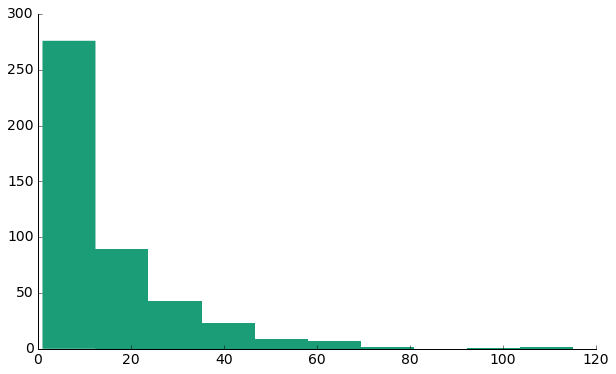

In [94]:
# drop respondents who have no missing
freq0_wo_zero = [v for v in freq0 if v>0]

# mean and median of missing months per respondent
print 'mean: %s, median: %s'%(np.mean(freq0_wo_zero), np.median(freq0_wo_zero))

# plot histogram
plt.hist(freq0_wo_zero)
remove_border()

### status 2 - working, with missing hours

In [95]:
freq2 = res_df.apply(lambda row: count_status_per_R(row, 2), axis=1)
print "%s respondents have no month working with missing hours"%sum([v==0 for v in freq2])

3134 respondents have no month working with missing hours


mean: 12.6466666667, median: 10.0


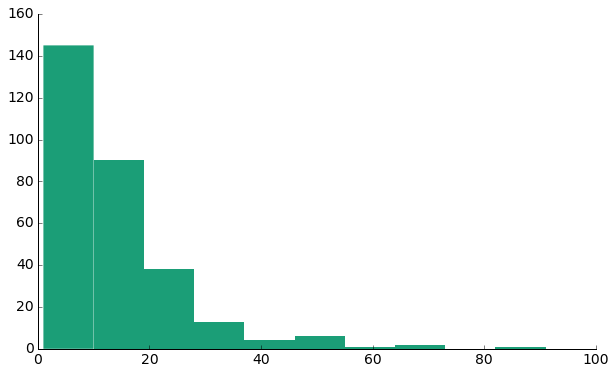

In [96]:
# drop respondents who have no month working with missing hours
freq2_wo_zero = [v for v in freq2 if v>0]

# mean and median of missing months per respondent
print 'mean: %s, median: %s'%(np.mean(freq2_wo_zero), np.median(freq2_wo_zero))

# plot histogram
plt.hist(freq2_wo_zero)
remove_border()